In [1]:
%matplotlib inline

In [35]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os

def findFiles(path): return glob.glob(path)

# print(findFiles('data/names/*.txt'))

import unicodedata
import string

all_letters = string.ascii_letters + " .,;-"
n_letters = len(all_letters)

# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

print(unicodeToAscii('Ślusàrski'))

# Build the category_lines dictionary, a list of names per language
category_lines = {}
all_categories = []

import pandas
df = pandas.read_csv('data/name_gender_dataset.csv')
data = df[["Gender", "Name"]]
homme = data.loc[df['Gender'] == 'M']
femme = data.loc[df['Gender'] == 'F']

conc = [homme, femme]
data = pandas.concat(conc)

all_categories = ['M', 'F']
category_lines = {}
category_lines["M"] = homme["Name"].to_numpy()
category_lines["F"] = femme["Name"].to_numpy()

category_lines

    

n_categories = len(all_categories)

Slusarski


In [36]:
all_categories

['M', 'F']

In [37]:
import torch

# Find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

print(letterToTensor('J'))

print(lineToTensor('Jones').size())

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])
torch.Size([5, 1, 57])


In [38]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)

In [45]:
input = letterToTensor('A')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input, hidden)
print(output)

input = lineToTensor('Fredo')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input[0], hidden)
print(output)



tensor([[-0.7327, -0.6551]], grad_fn=<LogSoftmaxBackward0>)
tensor([[-0.6788, -0.7077]], grad_fn=<LogSoftmaxBackward0>)


In [46]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

print(categoryFromOutput(output))

('M', 0)


In [48]:
import random

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ name =', line)

category = F / name = Auriel
category = M / name = James-David
category = M / name = Keghan
category = F / name = Adelayne
category = M / name = Anisjon
category = F / name = Rodrigo
category = F / name = Sheilla
category = F / name = Tamaika
category = F / name = Reilly
category = M / name = O'Che


In [49]:
criterion = nn.NLLLoss()

In [52]:
learning_rate = 0.01 # If you set this too high, it might explode. If too low, it might not learn

def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()

    rnn.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-(learning_rate*0.99))

    return output, loss.item()

In [53]:
import time
import math

n_iters = 300000
print_every = 5000
plot_every = 1000



# Keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

/home/lyo/miniconda3/envs/dicklearn/lib/python3.9/site-packages/torch/autograd/__init__.py:154: UserWarning: CUDA initialization: Unexpected error from cudaGetDeviceCount(). Did you run some cuda functions before calling NumCudaDevices() that might have already set an error? Error 803: system has unsupported display driver / cuda driver combination (Triggered internally at  /opt/conda/conda-bld/pytorch_1639180549130/work/c10/cuda/CUDAFunctions.cpp:112.)
  Variable._execution_engine.run_backward(


5000 1% (0m 5s) 0.2772 Yeudiel / M ✓
10000 3% (0m 10s) 0.4961 Marinah / F ✓
15000 5% (0m 15s) 0.5287 Shontae-Tori / F ✓
20000 6% (0m 20s) 0.5749 Malkeet / M ✓
25000 8% (0m 25s) 0.3264 Jasiyah / F ✓
30000 10% (0m 31s) 0.1250 Yyork / M ✓
35000 11% (0m 36s) 0.6529 Rozmeri / F ✓
40000 13% (0m 41s) 0.0275 Melina / F ✓
45000 15% (0m 46s) 0.1304 Kameka / F ✓
50000 16% (0m 51s) 0.2689 Cheville / F ✓
55000 18% (0m 56s) 0.3158 Lyckan / M ✓
60000 20% (1m 1s) 0.3390 Mister / M ✓
65000 21% (1m 6s) 0.6562 Shadric / M ✓
70000 23% (1m 11s) 0.8272 Jaii / F ✗ (M)
75000 25% (1m 16s) 0.0814 Dezhaun / M ✓
80000 26% (1m 21s) 0.1949 Teata-Mae / F ✓
85000 28% (1m 26s) 0.5938 Azareel / M ✓
90000 30% (1m 32s) 3.4457 Brayden-Shayne / F ✗ (M)
95000 31% (1m 37s) 0.3171 Tushara / F ✓
100000 33% (1m 42s) 0.4164 Ericamarie / F ✓
105000 35% (1m 47s) 0.2973 Jigarjeet / M ✓
110000 36% (1m 52s) 0.0978 Had / M ✓
115000 38% (1m 57s) 0.1799 Windson / M ✓
120000 40% (2m 2s) 0.3513 Aujoni / F ✓
125000 41% (2m 7s) 0.1228 Tarja

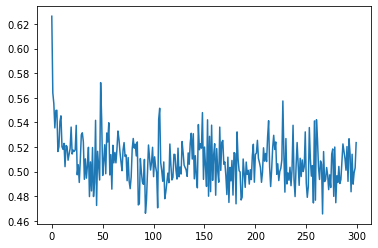

In [54]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

/tmp/ipykernel_80382/3585656379.py:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + all_categories, rotation=90)
/tmp/ipykernel_80382/3585656379.py:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + all_categories)


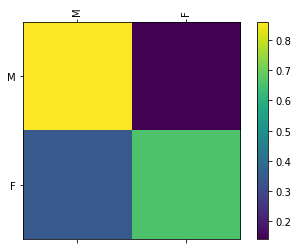

In [55]:
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# Just return an output given a line
def evaluate(line_tensor):
    hidden = rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

In [57]:
def predict(input_line, n_predictions=1):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(lineToTensor(input_line))

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

predict('Eliott')
predict('Baptiste')
predict('Manon')
predict('Jules')
predict('Clara')
predict('Sami')
predict('Hugo')


> Eliott
(-0.36) M

> Baptiste
(-0.65) M

> Manon
(-0.14) M

> Jules
(-0.10) M

> Clara
(-0.24) F

> Sami
(-0.66) M

> Hugo
(-0.04) M
